In [1]:
import utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from rtfm import featurizer as X

In [3]:
verbose = False
vprint = print if verbose else lambda *args, **kwargs: None

In [4]:
class MCTS():
    def __init__(self, 
                 simulator,
                 valid_actions,
                 ucb_c,
                 discount,
                 max_actions,
                 root=None,
                 render=False):
        """
        Monte Carlo Tree Search assuming deterministic dynamics.
        
        simulator: 
            wrapper of the environment that returns a scalar reward, a list of valid actions 
            and a 'done' boolean flag when presented with an action
        valid_moves:
            list of valid moves for the root node
        ucb_c:
            Constantused in the UCB1 formula for trees
            UCB(s,a) = Q(s,a) + ucb_c*sqrt(log N(s,a)/(\sum_b N(s,b)))
        discount:
            discoung factor gamma of the MDP
        max_actions:
            number of actions to be taken at most from the root node to the end of a rollout
        root: 
            might be the child of an old root node; use it to keep all the cached computations 
            from previous searches with a different root node. 
        """
        self.simulator = simulator
        self.original_dict = simulator.save_state_dict()
        self.valid_actions = valid_actions
        self.action_space = len(valid_actions)
        self.ucb_c = ucb_c
        self.discount = discount
        self.max_actions = max_actions
        self.root = root
        self.render = render
    
    def get_subtree(self, action):
        """
        Returns the subtree whose root node is the current root's child corresponding to
        the given action.
        """
        return self.root.children[action]
    
    def run(self, num_simulations):
        """
        Runs num_simulations searches starting from the root node corresponding to the internal
        state of the simulator given during initialization.
        Returns the root node and an extra_info dictionary
        """
        if self.root is None:
            self.root = Node()
            self.root.expand(
                self.valid_actions,
                0, # reward to get to root
                False, # terminal node
                self.simulator # state of the simulator at the root node 
            )
            # not sure about this
            self.root.visit_count += 1
        
        max_tree_depth = 0
        root = self.root
        for n in range(num_simulations):
            ### Start of a simulation/search ###
            vprint("\nSimulation %d started."%(n+1))
            node = root
            # make sure that the simulator internal state is reset to the original one
            self.simulator.load_state_dict(root.simulator_dict)
            search_path = [node]
            current_tree_depth = 0
            if self.render:
                node.render(self.simulator)
            ### Selection phase until leaf node is reached ###
            while node.expanded or (current_tree_depth<self.max_actions):
                current_tree_depth += 1
                action, node = self.select(node)
                if self.render and node.expanded:
                    node.render(self.simulator)
                vprint("Current tree depth: ", current_tree_depth)
                vprint("Action selected: ", action)
                vprint("Child node terminal: ", node.terminal)
                vprint("Child node expanded: ", node.expanded)
                if node.expanded or node.terminal:
                    search_path.append(node)
                    if node.terminal:
                        break
                else:
                    break
                
            ### Expansion of leaf node (if not terminal)###
            vprint("Expansion phase started")
            if not node.terminal:
                parent = search_path[-1] # last expanded node on the search path
                node = self.expand(node, parent, action)
                if self.render:
                    node.render(self.simulator)
                search_path.append(node)
            
            ### Simulation phase for self.max_actions - current_tree_depth steps ###
            vprint("Simulation  phase started")
            value = self.simulate(node, current_tree_depth)
            vprint("Simulated value: ", value)
            
            ### Backpropagation of the leaf node value along the seach_path ###
            vprint("Backpropagation phase started")
            self.backprop(search_path, value)
        
            max_tree_depth = max(max_tree_depth, current_tree_depth)
            vprint("Simulation %d done."%(n+1))
        extra_info = {
            "max_tree_depth": max_tree_depth
        }
        # just a check to see if root works as a shallow copy of self.root
        assert root.visit_count == self.root.visit_count, "self.root not updated during search"
        
        # make sure that the simulator internal state is reset to the original one
        self.simulator.load_state_dict(root.simulator_dict)
        return root, extra_info
        
    def select(self, node):
        """
        Use UCT formula on the input node; return the action selected and the corresponding child node 
        """
        actions = []
        ucb_values = []
        for action, child in node.children.items():
            actions.append(action)
            ucb_values.append(self.ucb_score(node, child))
        actions = np.array(actions)
        vprint("actions: ", actions)
        
        ucb_values = np.array(ucb_values)
        vprint("ucb_values: ", ucb_values)
        
        max_U = ucb_values.max()
        vprint("max_U: ", max_U)
        
        mask = (ucb_values==max_U)
        vprint("mask: ", mask)
        
        best_actions = actions[mask]
        vprint("best_actions: ", best_actions)
        
        action = np.random.choice(best_actions)
        return action, node.children[action]

    def ucb_score(self, parent, child, eps=1e-3):
        """
        The score for a node is based on its value, plus an exploration bonus.
        """
        exploration_term = self.ucb_c*np.sqrt(np.log(parent.visit_count)/(child.visit_count+eps))

        if child.visit_count > 0:
            # Mean value Q
            value_term = child.reward + self.discount*child.value() 
        else:
            value_term = 0

        return value_term + exploration_term
    
    def expand(self, node, parent, action):
        """
        Expand the node obtained by taking the given action from the parent node 
        """
        simulator = parent.get_simulator(self.simulator) # get a deepcopy of the simulator with the parent's state stored
        valid_actions, reward, done = simulator.step(action) # this also updates the simulator's internal state
        vprint("reward: ", reward)
        vprint("done: ", done)
        node.expand(valid_actions, reward, done, simulator)
        return node
    
    def simulate(self, node, current_depth):
        """
        Simulate a rollout with a random policy starting from the input node
        until the end of the episode or self.max_actions are reached 
        (also considering the current depth of the input node from the root)
        """
        if not node.terminal:
            simulator = node.get_simulator(self.simulator)
            valid_actions = node.valid_actions
            steps = self.max_actions - current_depth
            cum_discounted_reward = 0
            for i in range(steps):
                action = np.random.choice(valid_actions)
                valid_actions, reward, done = simulator.step(action)
                cum_discounted_reward += (self.discount**i)*reward
                if done:
                    break
        else:
            cum_discounted_reward = 0
        return cum_discounted_reward
            
    def backprop(self, search_path, value):
        """
        Update the value sum and visit count of all nodes along the search path.
        """
        for node in reversed(search_path):
            node.value_sum += value
            node.visit_count += 1
            value = node.reward + self.discount*value

In [5]:
class Node:
    def __init__(self):
        self.visit_count = 0
        self.value_sum = 0
        self.children = {}
        self.reward = 0
        self.simulator = None
        self.expanded = False
        self.terminal = False
        self.simulator_dict = None

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def expand(self, valid_actions, reward, done, simulator):
        self.expanded = True
        vprint("Valid actions as child: ", valid_actions)
        vprint("Terminal node: ", done)
        self.reward = reward
        self.terminal = done
        self.valid_actions = valid_actions
        if not done:
            for action in valid_actions:
                self.children[action] = Node()
        self.simulator_dict = simulator.save_state_dict()
        
    def get_simulator(self, simulator):
        if self.simulator_dict is not None:
            # load a deepcoy of the simulator_dict, so that the internal variable remains unchanged
            simulator.load_state_dict(copy.deepcopy(self.simulator_dict)) 
            return simulator
        else:
            print("Trying to load simulator_dict, but it was never instantiated.")
            raise NotImplementedError()
    
    def best_action(self, discount):
        """
        Look among the children and take the one with higher Q-value. 
        Exclude children with 0 visits.
        """
        actions = []
        Qvalues = []
        for action, child in self.children.items():
            actions.append(action)
            Qvalues.append(child.reward + discount*child.value())
        actions = np.array(actions)
        Qvalues = np.array(Qvalues)
        max_Q = Qvalues.max()
        mask = (Qvalues==max_Q)
        best_actions = actions[mask]
        return np.random.choice(best_actions)
    
    def render(self, simulator):
        if self.simulator_dict is not None:
            simulator.load_state_dict(self.simulator_dict)
            simulator.render()
        else:
            raise Exception("Node simulator not initialized yet.")

In [6]:
class TrueSimulator():
    """
    Returns only valid actions, reward and done signal from env.step() - no state is returned
    """
    def __init__(self, env, featurizer=None):
        self.env = env
        self.action_space = len(gym_env.action_space)
        self.featurizer = featurizer
        
    def reset(self):
        frame = self.env.reset()
        valid_moves = frame['valid'].numpy().astype(bool) # boolean mask of shape (action_space)
        actions = np.arange(self.action_space)
        valid_actions = actions[valid_moves]
        return valid_actions
    
    def step(self, action, *args, **kwargs):
        frame, reward, done, _ = self.env.step(int(action), *args, **kwargs)
        valid_moves = frame['valid'].numpy().astype(bool) # boolean mask of shape (action_space)
        actions = np.arange(self.action_space)
        valid_actions = actions[valid_moves]
        return valid_actions, reward, done
    
    def render(self):
        self.featurizer.featurize(self.env)
        
    def save_state_dict(self):
        return self.env.save_state_dict()
        
    def load_state_dict(self, d):
        self.env.load_state_dict(d)

In [7]:
### Define parameters ###
ucb_C = 1.0
discount = 0.997
episode_length = 50
max_actions = 100
num_simulations = 50

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
#gym_env = utils.create_env(flags, featurizer=X.Concat([X.Text(), X.ValidMoves(), X.Render()]))
featurizer = X.Render()
game_simulator = TrueSimulator(gym_env, featurizer)

In [8]:
game_simulator.render()


██████
█    █
█ n@ █
█! y?█
█    █
██████



In [9]:
def show_root_summary(root, discount):
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    
    for action, child in root.children.items():
        Q =  child.reward + discount*child.value()
        visits = child.visit_count
        print("Action ", action_dict[action], ": Q-value=%.3f - Visit counts=%d"%(Q,visits))

In [10]:
def play_episode_v0(
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    render = True,
    debug_render=False
):
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    for i in range(episode_length):
        mcts = MCTS(env, valid_actions, ucb_C, discount, max_actions, render=debug_render)
        print("\n","-"*40)
        print("Performing MCTS step")
        root, info = mcts.run(num_simulations)
        show_root_summary(root, discount)
        print("-"*40)
        print("Tree info: ", info)
        action = root.best_action(discount)
        print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        valid_actions, reward, done = env.step(action)
        if render:
            env.render()
        print("Reward received: ", reward)
        print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward

In [11]:
def play_episode_v1(
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    render = True,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    for i in range(episode_length):
        mcts = MCTS(env, valid_actions, ucb_C, discount, max_actions, render=debug_render, root=new_root)
        print("Performing MCTS step")
        root, info = mcts.run(num_simulations)
        show_root_summary(root, discount)
        print("Tree info: ", info)
        action = root.best_action(discount)
        print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        new_root = mcts.get_subtree(action)
        valid_actions, reward, done = env.step(action)
        if render:
            env.render()
        print("Reward received: ", reward)
        print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward

In [12]:
import time

In [13]:
%%time
R = play_episode_v0(
    game_simulator,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    debug_render=False
)


██████
█ @n!█
█ y  █
█    █
█  ? █
██████


 ----------------------------------------
Performing MCTS step
Action  Stay : Q-value=-0.948 - Visit counts=7
Action  Down : Q-value=-0.625 - Visit counts=24
Action  Left : Q-value=-0.788 - Visit counts=12
Action  Right : Q-value=-0.961 - Visit counts=7
----------------------------------------
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█  n!█
█ @  █
█    █
█  ? █
██████
blessed sword
Reward received:  0
Done:  False

 ----------------------------------------
Performing MCTS step
Action  Stay : Q-value=-0.755 - Visit counts=10
Action  Up : Q-value=-0.912 - Visit counts=6
Action  Down : Q-value=-0.759 - Visit counts=10
Action  Left : Q-value=-0.738 - Visit counts=10
Action  Right : Q-value=-0.128 - Visit counts=14
----------------------------------------
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█  n!█
█  @ █
█    █
█  ? █
██████
blessed sword
Reward received:  0
Done:  

In [14]:
%%time
R = play_episode_v1(
    game_simulator,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    debug_render=False
)


██████
█  ? █
█n  !█
█  y@█
█    █
██████

Performing MCTS step
Action  Stay : Q-value=0.069 - Visit counts=15
Action  Up : Q-value=-1.000 - Visit counts=2
Action  Down : Q-value=-0.856 - Visit counts=2
Action  Left : Q-value=0.492 - Visit counts=31
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  3 (Left)

██████
█  ? █
█n  !█
█  @ █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.935 - Visit counts=2
Action  Up : Q-value=-0.303 - Visit counts=3
Action  Down : Q-value=0.011 - Visit counts=4
Action  Left : Q-value=-0.896 - Visit counts=2
Action  Right : Q-value=0.857 - Visit counts=69
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█  ? █
█n  !█
█   @█
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.011 - Visit counts=4
Action  Up : Q-value=1.000 - Visit counts=101
Action  Down : Q-value=0.399 - Visit counts=10
Action  Left

In [16]:
R

1

## Introducing a value network

**TODO**
- define a **value target** with which to train the value net
- choose on which data to train (whole trajectory? just one trajectory or many? on-policy or with experience replay?)
- define training cycle

**EXTRA**
- use some muti-threaded application, like torch.multiprocessing, to run many episodes in parallel; adapt code from IMPALA

**DONE**
- **make the simulations faster** (function to set the state of the simulator instead of having to make a deepcopy every time?) 
- get the **state** to predict the value
- define a **ValueNet** architecture that can process frame dictionaries with the batch dimension included

In [15]:
class FullTrueSimulator():
    """
    Returns the full state from the environment step.
    """
    def __init__(self, env, featurizer=None):
        self.env = env
        self.action_space = len(gym_env.action_space)
        self.featurizer = featurizer
        
    def _process_frame(self, frame):
        """
        Extracts from frame a valid_action numpy array containing integers from 0 to self.action_space-1
        Adds batch dimension to all values stored inside frame dictionary
        """
        # do this before batch dim is added
        valid_moves = frame['valid'].numpy().astype(bool) # boolean mask of shape (action_space)
        actions = np.arange(self.action_space)
        valid_actions = actions[valid_moves]
        
        for k in frame.keys():
            frame[k] = frame[k].unsqueeze(0)
        
        return frame, valid_actions
    
    def reset(self):
        frame = self.env.reset()
        frame, valid_actions = self._process_frame(frame)
        return frame, valid_actions
    
    def step(self, action, *args, **kwargs):
        frame, reward, done, _ = self.env.step(int(action), *args, **kwargs)
        frame, valid_actions = self._process_frame(frame)
        return frame, valid_actions, reward, done
    
    def render(self):
        self.featurizer.featurize(self.env)
        
    def save_state_dict(self):
        return self.env.save_state_dict()
        
    def load_state_dict(self, d):
        self.env.load_state_dict(d)

In [16]:
class FixedDynamicsValueNet(nn.Module):
    def __init__(self, 
                 gym_env,
                 emb_dim=10,
                ):
        super().__init__()
        self.embedding = nn.Embedding(len(gym_env.vocab), emb_dim)
        
        name_shape = gym_env.observation_space['name']
        inv_shape = gym_env.observation_space['inv']
        n_channels = (name_shape[2]*name_shape[3]+inv_shape[0])*emb_dim
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1)
        )

        self.maxpool = nn.MaxPool2d(gym_env.observation_space['name'][1])

        self.value_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        
    def forward(self, frame):
        device = next(self.parameters()).device
        x = self.embedding(frame['name'].to(device))
        s = x.shape
        B, W, H = s[:3]
        x = x.reshape(*s[:3],-1).permute(0, 3, 1, 2)
        inv = self.embedding(frame['inv'].to(device))
        inv = inv.reshape(B,-1,1,1)
        inv = inv.expand(B,-1,W,H)
        z = torch.cat([x,inv], axis=1)
        z_conv = self.conv_net(z)
        z_flat = self.maxpool(z_conv).view(B,-1)
        v = self.value_mlp(z_flat)
        return v

In [17]:
game_simulator = FullTrueSimulator(gym_env, featurizer)

In [18]:
frame, valid_actions = game_simulator.reset()

In [19]:
value_net = FixedDynamicsValueNet(gym_env)

In [20]:
v = value_net(frame)
v

tensor([[-0.0035]], grad_fn=<AddmmBackward>)

### Value Network and Value Target

#### When and why the value network is used?
As a default all our information about the value of a state comes from a single rollout of a random policy. 
In general this is highly inaccurate, since the probability of executing the optimal sequence of decisions from a given state is exponentially decreasing with the number of steps $t$ taken during the rollout (e.g. $~|A|^{-t}$). In our specific case it's more a proxy signal for how likely it is that a good, neutral or bad outcome is obtained from the current state; for instance if we are near the goal state (which is an absorbing state), there is a relevant probability of getting there, especially if many simulations are directed to the node from which the rollout starts.

The idea about the value network is that it should learn to predict given some policy what is the EXPECTED value if we made infinite rollouts from there following that policy. This in general will be a BIASED estimate but with LOWER VARIANCE than a Monte Carlo rollout. 

#### On which states is trained?
The value network is trained to predict the value of the root nodes, i.e. the states actually visited along a trajectory, which are also the states on which we possess better informations thanks to the MCTS. 

#### On which target is trained?
This is the key question, since it determines of which policy are we estimating the value. If we were to estimate the value of the rollout policy, this would be guaranteed to be smaller or at best equal to the value of the MCTS policy (that is, the policy that runs $n$ simulations arranged in a tree and selects the action corresponding to the highest Q-value, or the most visited child). 

I think that the most sensible way to train the network is to use the formula:
$$
V_{trg}^{\pi_{mcts}}(s_t) = \sum_{k=0}^{n-1}\gamma^k r_{t+k} + \gamma^n \hat{V}(s_t+n)
$$

In [21]:
class ValueNode(Node):
    def __init__(self):
        super().__init__()
        self.frame = None

    def expand(self, frame, valid_actions, reward, done, simulator):
        self.expanded = True
        vprint("Valid actions as child: ", valid_actions)
        vprint("Terminal node: ", done)
        self.frame = frame
        self.reward = reward
        self.terminal = done
        self.valid_actions = valid_actions
        if not done:
            for action in valid_actions:
                self.children[action] = ValueNode()
        self.simulator_dict = simulator.save_state_dict()
        

In [22]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print("Using device "+device)

Using device cuda:0


In [28]:
class ValueMCTS(MCTS):
    def __init__(self, 
                 root_frame,
                 simulator,
                 valid_actions,
                 ucb_c,
                 discount,
                 max_actions,
                 value_net,
                 root=None,
                 render=False):
        
        super().__init__(simulator,
                     valid_actions,
                     ucb_c,
                     discount,
                     max_actions,
                     root,
                     render)
        self.value_net = value_net
        self.root_frame = root_frame
        
    def run(self, num_simulations):
        """
        Runs num_simulations searches starting from the root node corresponding to the internal
        state of the simulator given during initialization.
        Returns the root node and an extra_info dictionary
        """
        if self.root is None:
            self.root = ValueNode()
            self.root.expand(
                self.root_frame,
                self.valid_actions,
                0, # reward to get to root
                False, # terminal node
                self.simulator # state of the simulator at the root node 
            )
            # not sure about this
            self.root.visit_count += 1
        
        max_tree_depth = 0
        root = self.root
        for n in range(num_simulations):
            ### Start of a simulation/search ###
            vprint("\nSimulation %d started."%(n+1))
            node = root
            # make sure that the simulator internal state is reset to the original one
            self.simulator.load_state_dict(root.simulator_dict)
            search_path = [node]
            current_tree_depth = 0
            if self.render:
                node.render(self.simulator)
            ### Selection phase until leaf node is reached ###
            while node.expanded or (current_tree_depth<self.max_actions):
                current_tree_depth += 1
                action, node = self.select(node)
                if self.render and node.expanded:
                    node.render(self.simulator)
                vprint("Current tree depth: ", current_tree_depth)
                vprint("Action selected: ", action)
                vprint("Child node terminal: ", node.terminal)
                vprint("Child node expanded: ", node.expanded)
                if node.expanded or node.terminal:
                    search_path.append(node)
                    if node.terminal:
                        break
                else:
                    break
                
            ### Expansion of leaf node (if not terminal)###
            vprint("Expansion phase started")
            if not node.terminal:
                parent = search_path[-1] # last expanded node on the search path
                node = self.expand(node, parent, action)
                if self.render:
                    node.render(self.simulator)
                search_path.append(node)
            
            ### Simulation phase for self.max_actions - current_tree_depth steps ###
            vprint("Value prediction phase started")
            value = self.simulate_and_predict(node, current_tree_depth)
            #value = self.simulate(node, current_tree_depth)
            vprint("Predicted value: ", value)
            
            ### Backpropagation of the leaf node value along the seach_path ###
            vprint("Backpropagation phase started")
            self.backprop(search_path, value)
        
            max_tree_depth = max(max_tree_depth, current_tree_depth)
            vprint("Simulation %d done."%(n+1))
        extra_info = {
            "max_tree_depth": max_tree_depth
        }
        # just a check to see if root works as a shallow copy of self.root
        assert root.visit_count == self.root.visit_count, "self.root not updated during search"
        
        # make sure that the simulator internal state is reset to the original one
        self.simulator.load_state_dict(root.simulator_dict)
        return root, extra_info
    
    def expand(self, node, parent, action):
        """
        Expand the node obtained by taking the given action from the parent node 
        """
        simulator = parent.get_simulator(self.simulator) # get a deepcopy of the simulator with the parent's state stored
        frame, valid_actions, reward, done = simulator.step(action) # this also updates the simulator's internal state
        vprint("reward: ", reward)
        vprint("done: ", done)
        node.expand(frame, valid_actions, reward, done, simulator)
        return node
    
    def predict(self, node):
        with torch.no_grad():
            value = self.value_net(node.frame)
        return value.item()
    
    def simulate(self, node, current_depth):
        """
        Simulate a rollout with a random policy starting from the input node
        until the end of the episode or self.max_actions are reached 
        (also considering the current depth of the input node from the root)
        """
        if not node.terminal:
            simulator = node.get_simulator(self.simulator)
            valid_actions = node.valid_actions
            steps = self.max_actions - current_depth
            cum_discounted_reward = 0
            for i in range(steps):
                action = np.random.choice(valid_actions)
                frame, valid_actions, reward, done = simulator.step(action)
                cum_discounted_reward += (self.discount**i)*reward
                if done:
                    break
        else:
            cum_discounted_reward = 0
        return cum_discounted_reward
    
    def simulate_and_predict(self, node, current_depth, n_steps=5):
        """
        Simulate a rollout with a random policy starting from the input node
        until the end of the episode or self.max_actions are reached 
        (also considering the current depth of the input node from the root)
        or at most n_steps before calling the value_net to approximate the rest of the trajectory.
        """
        if not node.terminal:
            simulator = node.get_simulator(self.simulator)
            valid_actions = node.valid_actions
            steps = min(self.max_actions - current_depth, n_steps)
            cum_discounted_reward = 0
            for i in range(steps):
                action = np.random.choice(valid_actions)
                frame, valid_actions, reward, done = simulator.step(action)
                cum_discounted_reward += (self.discount**i)*reward
                if done:
                    break
            if not done:
                with torch.no_grad():
                    bootstrap_value = self.value_net(frame).item()
                cum_discounted_reward += (self.discount**steps)*bootstrap_value
        else:
            cum_discounted_reward = 0
        return cum_discounted_reward

In [29]:
def play_episode_value_net(
    value_net,
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    render = False,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    frame_lst = [frame]
    reward_lst = []
    done_lst = []
    for i in range(episode_length):
        mcts = ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        #print("Performing MCTS step")
        root, info = mcts.run(num_simulations)
        #show_root_summary(root, discount)
        #print("Tree info: ", info)
        action = root.best_action(discount)
        #print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        new_root = mcts.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        frame_lst.append(frame)
        reward_lst.append(reward)
        done_lst.append(done)
        
        if render:
            env.render()
        #print("Reward received: ", reward)
        #print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward, frame_lst, reward_lst, done_lst

In [40]:
def play_rollout_value_net(
        value_net,
        env,
        episode_length,
        ucb_C,
        discount,
        max_actions,
        num_simulations,
        render = False,
        debug_render=False
    ):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    frame_lst = [frame]
    reward_lst = []
    done_lst = []
    for i in range(episode_length):
        mcts = ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        if render:
            print("Performing MCTS step")
        root, info = mcts.run(num_simulations)
        if render:
            show_root_summary(root, discount)
            print("Tree info: ", info)
        action = root.best_action(discount)
        if render:
            print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        new_root = mcts.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        frame_lst.append(frame)
        reward_lst.append(reward)
        done_lst.append(done)
        
        if render:
            env.render()
            print("Reward received: ", reward)
            print("Done: ", done)
        total_reward += reward
        if done:
            frame, valid_actions = env.reset()
            done = False
            new_root = None
            
    return total_reward, frame_lst, reward_lst, done_lst

In [60]:
### Define parameters ###
ucb_C = 1.0
discount = 0.997
episode_length = 100
max_actions = 100
num_simulations = 50

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
#gym_env = utils.create_env(flags, featurizer=X.Concat([X.Text(), X.ValidMoves(), X.Render()]))
featurizer = X.Render()
game_simulator = FullTrueSimulator(gym_env, featurizer)
value_net = FixedDynamicsValueNet(gym_env).to(device)
optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-2)
loss_fn = F.mse_loss

In [42]:
%%time
total_reward, frame_lst, reward_lst, done_lst = play_rollout_value_net(value_net,
                                                                        game_simulator,
                                                                        episode_length,
                                                                        ucb_C,
                                                                        discount,
                                                                        max_actions,
                                                                        num_simulations,
                                                                        render=True
                                                                        )


██████
█   ?█
█  n █
█ y  █
█  @!█
██████

Performing MCTS step
Action  Stay : Q-value=-0.579 - Visit counts=5
Action  Up : Q-value=-0.190 - Visit counts=18
Action  Left : Q-value=-0.098 - Visit counts=24
Action  Right : Q-value=-1.000 - Visit counts=3
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█   ?█
█  n █
█ y  █
█ @ !█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.134 - Visit counts=12
Action  Up : Q-value=0.087 - Visit counts=31
Action  Left : Q-value=-0.018 - Visit counts=19
Action  Right : Q-value=-0.244 - Visit counts=11
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

██████
█   ?█
█  n █
█ @  █
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.027 - Visit counts=9
Action  Up : Q-value=-0.134 - Visit counts=6
Action  Down : Q-value=0.375 - Visit counts=31
Action  Left : Q-value=0.123 - Visit counts=11
Action  Right : Q-valu

KeyboardInterrupt: 

In [80]:
def get_cumulative_rewards(rewards, discount, dones):
    cum_disc_rewards = []
    cum_r = 0
    for i,r in enumerate(reversed(rewards)):
        not_done = 1 - dones[-(i+1)]
        cum_r = not_done*discount*cum_r + r
        cum_disc_rewards.append (cum_r)
    cum_disc_rewards = torch.tensor(cum_disc_rewards[::-1])
    return cum_disc_rewards

In [90]:
class ReplayBuffer:
    def __init__(self, mem_size, discount):
        self.mem_size = mem_size
        self.discount = discount
        self.frame_buffer = []
        self.V_target_buffer = []
    
    def store_episode(self, frame_lst, reward_lst, done_lst):
        frames, targets = self.batch_episode(frame_lst, reward_lst, done_lst)
        self.frame_buffer.append(frames)
        self.V_target_buffer.append(targets)
        if len(self.frame_buffer) > self.mem_size:
            self.frame_buffer.pop(0)
            self.V_target_buffer.pop(0)
            
    def batch_episode(self, frame_lst, reward_lst, done_lst):
        episode_len = len(reward_lst)
        frames = {}
        for k in frame_lst[0].keys():
            k_value_lst = []
            for b in range(episode_len):
                k_value_lst.append(frame_lst[b][k])
            k_value_lst = torch.cat(k_value_lst, axis=0)
            frames[k] = k_value_lst.unsqueeze(0)
        rewards = torch.tensor(reward_lst).float()
        dones = torch.tensor(done_lst).float()
        targets = get_cumulative_rewards(rewards, self.discount, dones)
        
        return frames, targets.unsqueeze(0)
    
    def get_batch(self, batch_size):
        id_range = len(self.V_target_buffer)
        assert id_range >= batch_size, "Not enough samples stored to get this batch size"
        sampled_ids = np.random.choice(id_range, size=batch_size, replace=False)
        print("sampled_ids: ", sampled_ids)
        sampled_targets = torch.cat([self.V_target_buffer[i] for i in sampled_ids], axis=0)
        print("sampled_targets.shape: ", sampled_targets.shape)
        # batch together frames 
        sampled_frames = {}
        for k in self.frame_buffer[0].keys():
            key_values = torch.cat([self.frame_buffer[i][k] for i in sampled_ids], axis=0)
            print(k, key_values.shape)
            sampled_frames[k] = key_values
        return sampled_frames, sampled_targets

In [91]:
rb = ReplayBuffer(1000, discount)
for i in range(32):
    rb.store_episode(frame_lst, reward_lst, done_lst)

In [92]:
frames, targets = rb.get_batch(16)

sampled_ids:  [17 13  0 26 24 25  1  4 19  8 18  6 10 27 16 28]
sampled_targets.shape:  torch.Size([16, 100])
name torch.Size([16, 100, 6, 6, 2, 2])
name_len torch.Size([16, 100, 6, 6, 2])
inv torch.Size([16, 100, 2])
inv_len torch.Size([16, 100, 1])
wiki torch.Size([16, 100, 80])
wiki_len torch.Size([16, 100, 1])
task torch.Size([16, 100, 40])
task_len torch.Size([16, 100, 1])
valid torch.Size([16, 100, 5])


In [44]:
def batch_episode(frame_lst, reward_lst, done_lst, value_net, discount):
    """
    Single episode of varying length and no restarts in between. 
    batch_size is actually the temporal dimension.
    Keep it simple just to see if the training procedure works.
    """
    batch_size = len(reward_lst)
    frames = {}
    for k in frame_lst[0].keys():
        k_value_lst = []
        for b in range(batch_size):
            k_value_lst.append(frame_lst[b][k])
        k_value_lst = torch.cat(k_value_lst, axis=0)
        frames[k] = k_value_lst
    rewards = torch.tensor(reward_lst).float()
    dones = torch.tensor(done_lst).float()
    
    values = value_net(frames) # leave out last state's value
    targets = get_cumulative_rewards(rewards, discount, dones)
    return values, targets.to(device)

In [36]:
values, targets = batch_episode(frame_lst, reward_lst, done_lst, value_net, discount)

In [61]:
n_updates = 200
total_rewards = []
episode_lengths = []
losses = []
for i in range(n_updates):
    t0 = time.time()
    if (i+1)%50 == 0:
        render=True
    else:
        render=False
    total_reward, frame_lst, reward_lst, done_lst = play_rollout_value_net(value_net,
                                                                        game_simulator,
                                                                        episode_length,
                                                                        ucb_C,
                                                                        discount,
                                                                        max_actions,
                                                                        num_simulations,
                                                                        render
                                                                        )
    t1 = time.time()
    total_rewards.append(total_reward)
    episode_lengths.append(len(reward_lst))
    values, targets = batch_episode(frame_lst, reward_lst, done_lst, value_net, discount)
    print("\nEpisode %d - Total reward %d"%(i+1, total_reward))
    if (i+1)%10 == 0:
        print("Values: ", values.squeeze())
        print("Targets: ", targets)
    loss = loss_fn(values.squeeze(), targets)
    print("Loss: %.4f"%loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    t2 = time.time()
    rollout_time = (t1-t0)/60
    update_time = (t2-t1)/60
    print("Rollout time: %.2f - Update time: %.2f"%(rollout_time, update_time))


Episode 1 - Total reward 0
Loss: 0.0073
Rollout time: 1.14 - Update time: 0.00

Episode 2 - Total reward 0
Loss: 11.1406
Rollout time: 1.55 - Update time: 0.00

Episode 3 - Total reward 0
Loss: 0.0390
Rollout time: 1.11 - Update time: 0.00

Episode 4 - Total reward 7
Loss: 0.4768
Rollout time: 0.83 - Update time: 0.00

Episode 5 - Total reward 3
Loss: 0.2516
Rollout time: 0.85 - Update time: 0.00

Episode 6 - Total reward 0
Loss: 0.1004
Rollout time: 1.55 - Update time: 0.00

Episode 7 - Total reward 0
Loss: 0.0166
Rollout time: 1.59 - Update time: 0.00

Episode 8 - Total reward 1
Loss: 0.1088
Rollout time: 1.05 - Update time: 0.00

Episode 9 - Total reward 0
Loss: 0.0001
Rollout time: 1.15 - Update time: 0.00

Episode 10 - Total reward 1
Values:  tensor([-0.0866, -0.1832, -0.1888, -0.1920, -0.0903, -0.0876, -0.0903, -0.0903,
        -0.0895, -0.0903, -0.0895, -0.0868, -0.0895, -0.0903, -0.0903, -0.0876,
        -0.0876, -0.0903, -0.0876, -0.0876, -0.0876, -0.0876, -0.0876, -0.0876,
 


Episode 36 - Total reward 2
Loss: 0.1915
Rollout time: 1.12 - Update time: 0.00

Episode 37 - Total reward 1
Loss: 0.1811
Rollout time: 0.93 - Update time: 0.00

Episode 38 - Total reward 5
Loss: 0.0760
Rollout time: 1.01 - Update time: 0.00

Episode 39 - Total reward 3
Loss: 0.4920
Rollout time: 0.96 - Update time: 0.00

Episode 40 - Total reward 1
Values:  tensor([0.8874, 0.8830, 0.8833, 0.8830, 0.8827, 0.8838, 0.8838, 0.8833, 0.8830,
        0.8833, 0.8830, 0.8833, 0.8846, 0.8833, 0.8833, 0.8838, 0.8838, 0.8838,
        0.8838, 0.8827, 0.8827, 0.8827, 0.8827, 0.8760, 0.8827, 0.8827, 0.8827,
        0.8838, 0.8838, 0.8827, 0.8838, 0.8827, 0.8838, 0.8838, 0.8827, 0.8827,
        0.8830, 0.8819, 0.9387, 0.9398, 0.8758, 0.8758, 0.8758, 0.8753, 0.8758,
        0.8760, 0.8758, 0.8758, 0.8753, 0.8758, 0.8758, 0.8760, 0.8758, 0.8758,
        0.8753, 0.8758, 0.8760, 0.8758, 0.8760, 0.8760, 0.8749, 0.8760, 0.8760,
        0.8758, 0.8753, 0.8758, 0.8758, 0.8760, 0.8760, 0.8758, 0.8758, 0.8758


██████
█@!? █
█ n  █
█    █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.884 - Visit counts=41
Action  Down : Q-value=-0.380 - Visit counts=2
Action  Right : Q-value=1.000 - Visit counts=93
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█ @? █
█ n  █
█    █
█    █
██████
blessed sword
Reward received:  1
Done:  True
Performing MCTS step
Action  Stay : Q-value=-0.550 - Visit counts=14
Action  Down : Q-value=-1.000 - Visit counts=4
Action  Left : Q-value=-0.373 - Visit counts=26
Action  Right : Q-value=-0.785 - Visit counts=6
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  3 (Left)

██████
█@   █
█ ! ?█
█   y█
█ n  █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.490 - Visit counts=42
Action  Down : Q-value=-0.784 - Visit counts=12
Action  Right : Q-value=-0.639 - Visit counts=21
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:

Performing MCTS step
Action  Stay : Q-value=-0.096 - Visit counts=22
Action  Down : Q-value=-0.463 - Visit counts=7
Action  Left : Q-value=-0.583 - Visit counts=6
Action  Right : Q-value=-0.169 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█y@  █
█?   █
█  n!█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.215 - Visit counts=19
Action  Down : Q-value=-0.328 - Visit counts=13
Action  Left : Q-value=-0.532 - Visit counts=8
Action  Right : Q-value=-0.078 - Visit counts=31
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█y @ █
█?   █
█  n!█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.015 - Visit counts=29
Action  Down : Q-value=-0.098 - Visit counts=22
Action  Left : Q-value=-0.201 - Visit counts=14
Action  Right : Q-value=-0.170 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 

Action  Stay : Q-value=-0.288 - Visit counts=14
Action  Up : Q-value=-0.089 - Visit counts=30
Action  Down : Q-value=-0.380 - Visit counts=10
Action  Left : Q-value=-0.318 - Visit counts=11
Action  Right : Q-value=-0.317 - Visit counts=11
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

██████
█y @ █
█?   █
█  n!█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.633 - Visit counts=7
Action  Down : Q-value=-0.172 - Visit counts=27
Action  Left : Q-value=-0.170 - Visit counts=30
Action  Right : Q-value=-0.334 - Visit counts=15
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  3 (Left)

██████
█y@  █
█?   █
█  n!█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.430 - Visit counts=11
Action  Down : Q-value=-0.640 - Visit counts=7
Action  Left : Q-value=-0.482 - Visit counts=12
Action  Right : Q-value=-0.135 - Visit counts=49
Tree info:  {'max_tree_depth': 5}
Action 

Action  Stay : Q-value=-0.116 - Visit counts=38
Action  Down : Q-value=-0.748 - Visit counts=5
Action  Left : Q-value=-0.074 - Visit counts=43
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  3 (Left)

██████
█y @ █
█?   █
█  n!█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.091 - Visit counts=37
Action  Down : Q-value=-0.268 - Visit counts=17
Action  Left : Q-value=-0.267 - Visit counts=17
Action  Right : Q-value=-0.170 - Visit counts=21
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  0 (Stay)

██████
█y @ █
█?   █
█  n!█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.020 - Visit counts=38
Action  Down : Q-value=-0.251 - Visit counts=15
Action  Left : Q-value=-0.151 - Visit counts=22
Action  Right : Q-value=-0.317 - Visit counts=11
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█y @ █
█?   █
█  n!█
█    █
██████

Reward received:  


Episode 59 - Total reward 4
Loss: 0.2368
Rollout time: 0.82 - Update time: 0.00

Episode 60 - Total reward 4
Values:  tensor([0.4170, 0.4170, 0.4115, 0.4079, 0.4120, 0.4120, 0.4079, 0.4120, 0.4079,
        0.4120, 0.4120, 0.4139, 0.4120, 0.4120, 0.4139, 0.4167, 0.4139, 0.4139,
        0.4120, 0.4079, 0.4079, 0.4079, 0.4079, 0.4079, 0.4079, 0.4079, 0.4079,
        0.4079, 0.4120, 0.4120, 0.4079, 0.4079, 0.4120, 0.4139, 0.4139, 0.3961,
        0.3961, 0.3961, 0.3961, 0.3961, 0.4168, 0.4185, 0.4182, 0.3961, 0.3961,
        0.3961, 0.4089, 0.3961, 0.3961, 0.3961, 0.4134, 0.4127, 0.3961, 0.3961,
        0.3961, 0.4093, 0.4065, 0.4065, 0.4065, 0.4065, 0.4065, 0.4093, 0.4065,
        0.4070, 0.4150, 0.4070, 0.4065, 0.4093, 0.4065, 0.4065, 0.4065, 0.4093,
        0.4093, 0.4150, 0.4093, 0.4093, 0.4065, 0.4070, 0.4070, 0.4065, 0.4070,
        0.4065, 0.4093, 0.4093, 0.4065, 0.4093, 0.4065, 0.4093, 0.4065, 0.4065,
        0.4065, 0.4065, 0.4065, 0.4093, 0.4065, 0.4093, 0.4065, 0.4065, 0.4070,
 


Episode 91 - Total reward 3
Loss: 0.2317
Rollout time: 0.86 - Update time: 0.00

Episode 92 - Total reward 2
Loss: 0.2594
Rollout time: 0.94 - Update time: 0.00

Episode 93 - Total reward 5
Loss: 0.1561
Rollout time: 0.81 - Update time: 0.00

Episode 94 - Total reward 0
Loss: 0.3669
Rollout time: 1.14 - Update time: 0.00

Episode 95 - Total reward 0
Loss: 0.3712
Rollout time: 1.14 - Update time: 0.00

Episode 96 - Total reward 0
Loss: 0.3294
Rollout time: 1.54 - Update time: 0.00

Episode 97 - Total reward 4
Loss: 0.2350
Rollout time: 0.80 - Update time: 0.00

Episode 98 - Total reward 3
Loss: 0.1833
Rollout time: 1.37 - Update time: 0.00

Episode 99 - Total reward 2
Loss: 0.1943
Rollout time: 1.01 - Update time: 0.00

██████
█   n█
█ y  █
█  !?█
█@   █
██████

Performing MCTS step
Action  Stay : Q-value=0.052 - Visit counts=23
Action  Up : Q-value=0.099 - Visit counts=22
Action  Right : Q-value=-0.442 - Visit counts=5
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (U

Action  Stay : Q-value=0.196 - Visit counts=22
Action  Down : Q-value=0.290 - Visit counts=38
Action  Left : Q-value=0.205 - Visit counts=23
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█    █
█   @█
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.274 - Visit counts=25
Action  Up : Q-value=0.345 - Visit counts=36
Action  Down : Q-value=0.149 - Visit counts=15
Action  Left : Q-value=0.009 - Visit counts=11
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

██████
█   @█
█    █
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.305 - Visit counts=35
Action  Down : Q-value=0.127 - Visit counts=16
Action  Left : Q-value=0.302 - Visit counts=34
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█   @█
█    █
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False


Action  Stay : Q-value=0.236 - Visit counts=28
Action  Down : Q-value=0.291 - Visit counts=38
Action  Left : Q-value=0.246 - Visit counts=30
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█    █
█   @█
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.095 - Visit counts=19
Action  Up : Q-value=0.188 - Visit counts=21
Action  Down : Q-value=0.178 - Visit counts=20
Action  Left : Q-value=0.202 - Visit counts=27
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█    █
█  @ █
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.440 - Visit counts=5
Action  Up : Q-value=0.272 - Visit counts=37
Action  Down : Q-value=0.034 - Visit counts=14
Action  Left : Q-value=-0.648 - Visit counts=4
Action  Right : Q-value=0.126 - Visit counts=16
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)


Action  Stay : Q-value=0.266 - Visit counts=35
Action  Up : Q-value=0.011 - Visit counts=11
Action  Down : Q-value=0.225 - Visit counts=26
Action  Left : Q-value=0.110 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█    █
█   @█
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.318 - Visit counts=33
Action  Up : Q-value=0.285 - Visit counts=28
Action  Down : Q-value=-0.073 - Visit counts=9
Action  Left : Q-value=0.090 - Visit counts=14
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█    █
█   @█
█!?  █
█y   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.110 - Visit counts=20
Action  Up : Q-value=0.231 - Visit counts=27
Action  Down : Q-value=0.189 - Visit counts=25
Action  Left : Q-value=-0.028 - Visit counts=10
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

█

Action  Stay : Q-value=-0.226 - Visit counts=27
Action  Down : Q-value=-0.136 - Visit counts=40
Action  Right : Q-value=-0.390 - Visit counts=16
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  2 (Down)

██████
█    █
█@?  █
█  !n█
█ y  █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.205 - Visit counts=20
Action  Up : Q-value=-0.401 - Visit counts=14
Action  Down : Q-value=-0.089 - Visit counts=52
Action  Right : Q-value=-1.000 - Visit counts=3
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  2 (Down)

██████
█    █
█ ?  █
█@ !n█
█ y  █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.162 - Visit counts=14
Action  Up : Q-value=-0.401 - Visit counts=7
Action  Down : Q-value=0.369 - Visit counts=48
Action  Right : Q-value=0.056 - Visit counts=32
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  2 (Down)

██████
█    █
█ ?  █
█  !n█
█@y  █
██████

Reward received:  0
Done


Episode 121 - Total reward 0
Loss: 0.3632
Rollout time: 1.11 - Update time: 0.00

Episode 122 - Total reward 0
Loss: 0.2648
Rollout time: 1.09 - Update time: 0.00

Episode 123 - Total reward 6
Loss: 0.2490
Rollout time: 0.81 - Update time: 0.00

Episode 124 - Total reward 1
Loss: 0.2389
Rollout time: 0.97 - Update time: 0.00

Episode 125 - Total reward 0
Loss: 0.1029
Rollout time: 1.55 - Update time: 0.00

Episode 126 - Total reward 7
Loss: 0.2639
Rollout time: 0.73 - Update time: 0.00

Episode 127 - Total reward 3
Loss: 0.1302
Rollout time: 0.96 - Update time: 0.00

Episode 128 - Total reward 2
Loss: 0.1401
Rollout time: 0.96 - Update time: 0.00

Episode 129 - Total reward 1
Loss: 0.2081
Rollout time: 1.06 - Update time: 0.00

Episode 130 - Total reward 4
Values:  tensor([0.1597, 0.1659, 0.1659, 0.1659, 0.1659, 0.1577, 0.1577, 0.1659, 0.1659,
        0.1659, 0.1659, 0.1659, 0.1659, 0.1659, 0.1659, 0.1659, 0.1659, 0.1659,
        0.1659, 0.1659, 0.1659, 0.1659, 0.1659, 0.1659, 0.1659,

Action  Stay : Q-value=-0.185 - Visit counts=15
Action  Up : Q-value=-0.144 - Visit counts=20
Action  Left : Q-value=0.054 - Visit counts=42
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█n   █
█? ! █
█ y  █
█  @ █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.160 - Visit counts=14
Action  Up : Q-value=-0.039 - Visit counts=25
Action  Left : Q-value=0.069 - Visit counts=35
Action  Right : Q-value=-0.136 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█n   █
█? ! █
█ y  █
█ @  █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.044 - Visit counts=23
Action  Up : Q-value=0.053 - Visit counts=24
Action  Left : Q-value=0.101 - Visit counts=21
Action  Right : Q-value=-0.083 - Visit counts=16
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█n   █
█? ! █
█ y  █
█@   █
██████

Reward received:  0
Done:  F

Action  Stay : Q-value=-0.229 - Visit counts=8
Action  Up : Q-value=-1.000 - Visit counts=2
Action  Down : Q-value=0.499 - Visit counts=41
Action  Left : Q-value=-0.054 - Visit counts=13
Action  Right : Q-value=-0.383 - Visit counts=6
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█ n  █
█ ?  █
█    █
█ @ !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.104 - Visit counts=5
Action  Up : Q-value=-0.994 - Visit counts=2
Action  Left : Q-value=0.029 - Visit counts=6
Action  Right : Q-value=0.866 - Visit counts=77
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  4 (Right)

██████
█ n  █
█ ?  █
█    █
█  @!█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.985 - Visit counts=2
Action  Up : Q-value=0.166 - Visit counts=7
Action  Left : Q-value=0.139 - Visit counts=5
Action  Right : Q-value=1.000 - Visit counts=112
Tree info:  {'max_tree_depth

Action  Stay : Q-value=-0.381 - Visit counts=28
Action  Up : Q-value=-1.000 - Visit counts=5
Action  Left : Q-value=-0.165 - Visit counts=77
Action  Right : Q-value=-0.657 - Visit counts=11
Tree info:  {'max_tree_depth': 6}
Action selected from MCTS:  3 (Left)

██████
█ y ?█
█    █
█  ! █
█ @  █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.342 - Visit counts=17
Action  Up : Q-value=-0.226 - Visit counts=24
Action  Left : Q-value=-0.052 - Visit counts=69
Action  Right : Q-value=-0.379 - Visit counts=16
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  3 (Left)

██████
█ y ?█
█    █
█  ! █
█@   █
██████
shimmering sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-0.191 - Visit counts=26
Action  Up : Q-value=-0.108 - Visit counts=36
Action  Right : Q-value=-0.052 - Visit counts=56
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  4 (Right)

██████
█ y ?█
█    █
█  ! █
█ @  

Action  Stay : Q-value=0.356 - Visit counts=12
Action  Up : Q-value=0.741 - Visit counts=66
Action  Down : Q-value=0.254 - Visit counts=12
Action  Right : Q-value=0.079 - Visit counts=8
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  1 (Up)

██████
█ ! ?█
█@   █
█    █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.581 - Visit counts=19
Action  Up : Q-value=0.903 - Visit counts=75
Action  Down : Q-value=0.230 - Visit counts=6
Action  Right : Q-value=0.586 - Visit counts=15
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  1 (Up)

██████
█@! ?█
█    █
█    █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.886 - Visit counts=35
Action  Down : Q-value=0.685 - Visit counts=15
Action  Right : Q-value=1.000 - Visit counts=74
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█ @ ?█
█    █
█    █
█    █
██████
blessed swo

Action  Stay : Q-value=0.056 - Visit counts=21
Action  Up : Q-value=0.139 - Visit counts=27
Action  Left : Q-value=0.104 - Visit counts=23
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

██████
█  ? █
█!   █
█   @█
█ n  █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.157 - Visit counts=23
Action  Up : Q-value=-0.227 - Visit counts=8
Action  Down : Q-value=0.092 - Visit counts=21
Action  Left : Q-value=0.142 - Visit counts=24
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█  ? █
█!   █
█   @█
█ n  █
██████
blessed sword
Reward received:  0
Done:  False

Episode 150 - Total reward 10
Values:  tensor([0.2228, 0.2188, 0.2230, 0.2230, 0.2230, 0.2230, 0.2188, 0.2230, 0.2250,
        0.2156, 0.2250, 0.2352, 0.2352, 0.2352, 0.2352, 0.2352, 0.2352, 0.2352,
        0.2289, 0.2238, 0.2352, 0.2352, 0.2352, 0.2230, 0.2230, 0.2352, 0.2352,
        0.2352, 0.2352, 0.2362, 0.2352, 0.2352, 0.2352


Episode 174 - Total reward 2
Loss: 0.1777
Rollout time: 1.33 - Update time: 0.00

Episode 175 - Total reward 4
Loss: 0.2602
Rollout time: 0.78 - Update time: 0.00

Episode 176 - Total reward 2
Loss: 0.1822
Rollout time: 1.37 - Update time: 0.00

Episode 177 - Total reward 4
Loss: 0.2124
Rollout time: 1.10 - Update time: 0.00

Episode 178 - Total reward 0
Loss: 0.1560
Rollout time: 1.58 - Update time: 0.00

Episode 179 - Total reward 0
Loss: 0.1339
Rollout time: 1.15 - Update time: 0.00

Episode 180 - Total reward 2
Values:  tensor([0.3347, 0.3417, 0.3361, 0.3361, 0.3361, 0.3360, 0.3360, 0.3438, 0.3417,
        0.3417, 0.3417, 0.3361, 0.3361, 0.3361, 0.3360, 0.3361, 0.3361, 0.3360,
        0.3360, 0.3360, 0.3361, 0.3361, 0.3361, 0.3361, 0.3360, 0.3361, 0.3361,
        0.3361, 0.3361, 0.3361, 0.3361, 0.3361, 0.3361, 0.3361, 0.3361, 0.3361,
        0.3417, 0.3361, 0.3417, 0.3347, 0.3417, 0.3347, 0.3417, 0.3361, 0.3360,
        0.3361, 0.3361, 0.3417, 0.3438, 0.3360, 0.3361, 0.3361, 0.336

Action  Stay : Q-value=0.593 - Visit counts=15
Action  Down : Q-value=-0.111 - Visit counts=3
Action  Left : Q-value=0.891 - Visit counts=64
Action  Right : Q-value=0.400 - Visit counts=9
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█@   █
█!   █
█    █
█?n  █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.828 - Visit counts=28
Action  Down : Q-value=1.000 - Visit counts=78
Action  Right : Q-value=0.421 - Visit counts=7
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█    █
█@   █
█    █
█?n  █
██████
blessed sword
Reward received:  1
Done:  True
Performing MCTS step
Action  Stay : Q-value=0.125 - Visit counts=13
Action  Up : Q-value=-0.200 - Visit counts=5
Action  Down : Q-value=-0.049 - Visit counts=7
Action  Left : Q-value=0.264 - Visit counts=21
Action  Right : Q-value=-0.335 - Visit counts=4
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██

Action  Stay : Q-value=-0.112 - Visit counts=12
Action  Down : Q-value=0.022 - Visit counts=26
Action  Left : Q-value=0.100 - Visit counts=41
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  3 (Left)

██████
█y @ █
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.105 - Visit counts=30
Action  Down : Q-value=-0.178 - Visit counts=13
Action  Left : Q-value=-0.153 - Visit counts=11
Action  Right : Q-value=0.142 - Visit counts=36
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  4 (Right)

██████
█y  @█
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.125 - Visit counts=46
Action  Down : Q-value=-0.143 - Visit counts=14
Action  Left : Q-value=0.010 - Visit counts=25
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  0 (Stay)

██████
█y  @█
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-

Action  Stay : Q-value=-0.003 - Visit counts=28
Action  Down : Q-value=0.037 - Visit counts=32
Action  Left : Q-value=-0.033 - Visit counts=22
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█y   █
█?  @█
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.141 - Visit counts=36
Action  Up : Q-value=0.082 - Visit counts=27
Action  Down : Q-value=-0.152 - Visit counts=11
Action  Left : Q-value=-0.426 - Visit counts=7
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█y   █
█?  @█
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.123 - Visit counts=26
Action  Up : Q-value=0.205 - Visit counts=44
Action  Down : Q-value=-0.662 - Visit counts=4
Action  Left : Q-value=-0.152 - Visit counts=11
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  1 (Up)

██████
█y  @█
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False

Action  Stay : Q-value=0.062 - Visit counts=30
Action  Up : Q-value=0.122 - Visit counts=39
Action  Down : Q-value=-0.151 - Visit counts=11
Action  Left : Q-value=-0.549 - Visit counts=6
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  1 (Up)

██████
█y  @█
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.111 - Visit counts=37
Action  Down : Q-value=-0.050 - Visit counts=21
Action  Left : Q-value=0.063 - Visit counts=30
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  0 (Stay)

██████
█y  @█
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.136 - Visit counts=35
Action  Down : Q-value=-0.199 - Visit counts=10
Action  Left : Q-value=0.132 - Visit counts=41
Tree info:  {'max_tree_depth': 5}
Action selected from MCTS:  0 (Stay)

██████
█y  @█
█?   █
█    █
█ n! █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=-

Just using the value network predictions and the MC return, the network gets stuck either by playing Stay or two complementary actions that as a result cancel each other (e.g. Left+Right).

Second option tried: during the simulation/prediction of a leaf node, take at most n_steps of random rollouts and then bootstrap the end of the trajectory with the value network. This helps to mix the unbiased information from the true simulator and the low variance estimate of the value network.

Still it doesn't work. 

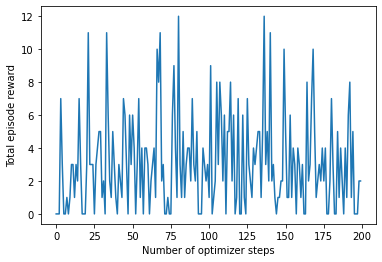

In [62]:
plt.plot(np.arange(n_updates), total_rewards)
plt.xlabel("Number of optimizer steps")
plt.ylabel("Total episode reward")
plt.show()

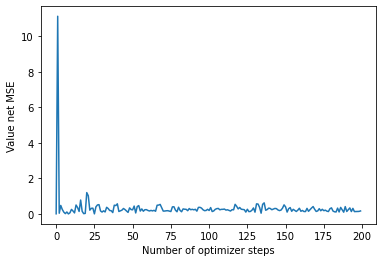

In [63]:
plt.plot(np.arange(n_updates), losses)
plt.xlabel("Number of optimizer steps")
plt.ylabel("Value net MSE")
plt.show()

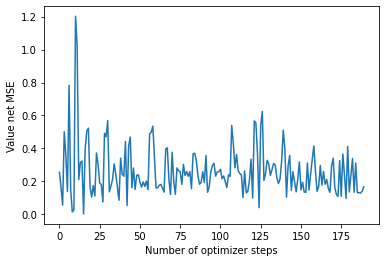

In [64]:
plt.plot(np.arange(n_updates-10), losses[10:])
plt.xlabel("Number of optimizer steps")
plt.ylabel("Value net MSE")
plt.show()

## Testing the value network without the MCTS

Idea:
$$
\pi(s) =  \arg \underset{a}{\max} r(s,a) + \gamma V(s')
$$

In [65]:
class Pi:
    def __init__(self,
                 simulator,
                 value_net,
                 discount
                ):
        self.simulator = simulator
        self.value_net = value_net
        self.discount = discount
        
        
    def get_action(self, valid_actions, simulator_state):
        Q_values = []
        for a in valid_actions:
            self.simulator.load_state_dict(copy.deepcopy(simulator_state))
            frame, valid_actions, reward, done = self.simulator.step(a)
            with torch.no_grad():
                value = self.value_net(frame).item()
            Q = reward + self.discount*value
            Q_values.append(Q)
        print("Q values: ", Q_values)
        best_id = np.argmax(Q_values)
        print("Best id: ", best_id)
        best_action = valid_actions[best_id]
        print("best action: ", best_action)
        return best_action

In [66]:
def test_value_policy(value_net, env, episode_length, discount, render = False):
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    
    policy = Pi(env, value_net, discount)
    frame, valid_actions = env.reset()
    print("valid actions: ", valid_actions)
    simulator_state = env.save_state_dict()
    if render:
        env.render()
    total_reward = 0
    done = False
    
    for i in range(episode_length):
        a = policy.get_action(valid_actions, simulator_state)
        print("Action selected from value policy: ", a, "({})".format(action_dict[a]))
        # reset internal state of the env
        env.load_state_dict(simulator_state)
        #if render:
        #    env.render()
        frame, valid_actions, reward, done = env.step(a)
        print("valid actions: ", valid_actions)
        simulator_state = env.save_state_dict()
        if render:
            env.render()
        print("Reward received: ", reward)
        print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward

In [67]:
test_value_policy(value_net, game_simulator, episode_length, discount, render = True)

valid actions:  [0 1 2 3]

██████
█n!? █
█    █
█y  @█
█    █
██████

Q values:  [0.3119818680882454, 0.31267251509428023, 0.3120264671742916, 0.3139860042333603]
Best id:  3
best action:  3
Action selected from value policy:  3 (Left)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.

Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  

Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  

Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  0
best action:  0
Action selected from value policy:  0 (Stay)
valid actions:  [0 1 2 3 4]

██████
█n!? █
█    █
█y @ █
█    █
██████

Reward received:  0
Done:  False
Q values:  [0.3139860042333603, 0.3099972830414772, 0.31338185152411463, 0.31187977451086046, 0.3119818680882454]
Best id:  

0